In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [7]:
def get_boston_data() -> pd.DataFrame:
    # load boston boston data into pandas DataFrame
    dt = datasets.load_boston()
    df = pd.DataFrame(dt.data)
    df.columns = dt.feature_names
    df['MEDVAL'] = dt.target
    return df, dt.DESCR

boston, descr = get_boston_data()

# transform CHAS from float to category
boston['CHAS'] = boston['CHAS'].astype('category')

In [8]:
# stratified random sample based on MEDVAL, the target variable
def stratified_sample(df: pd.DataFrame,
                      col: str,
                      cats: int,
                      n_splits: int,
                      test_size: float) -> (pd.DataFrame, pd.DataFrame):
    # label records according to col quintiles
    cut_column = col + '_cut'
    df[cut_column] = pd.qcut(df[col], 5, labels=False)

    # sample according to RM quintile
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    for train_index, test_index in split.split(df, df[cut_column]):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]

    # remove RM_cat column from test/training sets
    for set_ in (strat_train_set, strat_test_set):
        set_.drop(cut_column, axis=1, inplace=True)

    return strat_train_set, strat_test_set

train, test = stratified_sample(boston, 'MEDVAL', 5, 1, 0.2)
X = train.drop('MEDVAL', axis=1)
y = train['MEDVAL'].copy()

In [9]:
# numeric feature pipeline
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# list of numeric and categorical features, respectively
num_cols = list(X.select_dtypes(include=['float']))
cat_cols = list(X.select_dtypes(include=['category']))

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

X_prepared = pipeline.fit_transform(X)

In [10]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

def cv_compare(models):
    results = []
    for model in models:
        scores = cross_val_score(model, X_prepared, y, scoring='neg_mean_squared_error', cv=5)
        scores_sqrt = np.mean(np.sqrt(-scores))
        scores_std = np.std(np.sqrt(-scores))
        results.append([type(model), scores_sqrt, scores_std])
    return pd.DataFrame(results, columns=['type', 'rmse', 'std'])

results = cv_compare([lin_reg, tree_reg, rf_reg])

In [11]:
results

,type,rmse,std
0,<class 'sklearn.linear_model.base.LinearRegres...,4.639423,0.576759
1,<class 'sklearn.tree.tree.DecisionTreeRegressor'>,4.959310,0.934801
2,<class 'sklearn.ensemble.forest.RandomForestRe...,3.726798,0.565071


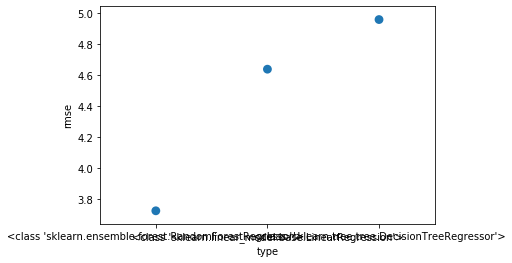

In [12]:
ax = sns.pointplot(x="type", 
                   y="rmse",  
                   ci='std',
                   data=results.sort_values(by='rmse'), 
                   join=False)